## Notebook description:
Let's analyze QTLs produced by A&B's algorithm from their recent paper.  
I ran their code on our old data, now it's time to analyze results using our tests.

## Imports section:

In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

# utilities
import gc
import time
import os
import sys

os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
sys.path.append(os.getcwd())
%aimport fs_utils

sys.path.append(fs_utils.LIB_DIR)
sys.path.append(fs_utils.SRC_DIR)

In [8]:
import collections
import itertools
from importlib import reload
import pickle

# data analysis tools
import joblib
import random
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import *
import qgrid

tqdm.monitor_interval = 0

# network analysis tools
import igraph as ig

# multiprocessing tools
import subprocess
import multiprocessing as mp

# visualization tools
import matplotlib.pyplot as plt

%aimport networks
%aimport qtls
%aimport util
%aimport ontologies

gc.enable()

%autosave 15

INTERACTOME_RANDITER = 1024

Autosaving every 15 seconds


## Data section:

In [11]:
qtls_df = {
    "eQTLs_2011_A&B" : pd.read_table("data/eQTLs/2011/qtls_albert&bloom_script_output.csv"),
    "pQTLs_2011_A&B" : pd.read_table("data/pQTLs/2011/qtls_albert&bloom_script_output.csv")
}

expression_df = {
    "eQTLs_2011" : pd.read_table("data/eQTLs/2011/expression.csv"),
    "pQTLs_2011" : pd.read_table("data/pQTLs/2011/expression.csv")
}

## Simple tests

First of all, let's take a look at the similarity of eQTL and pQTL sets in new data.

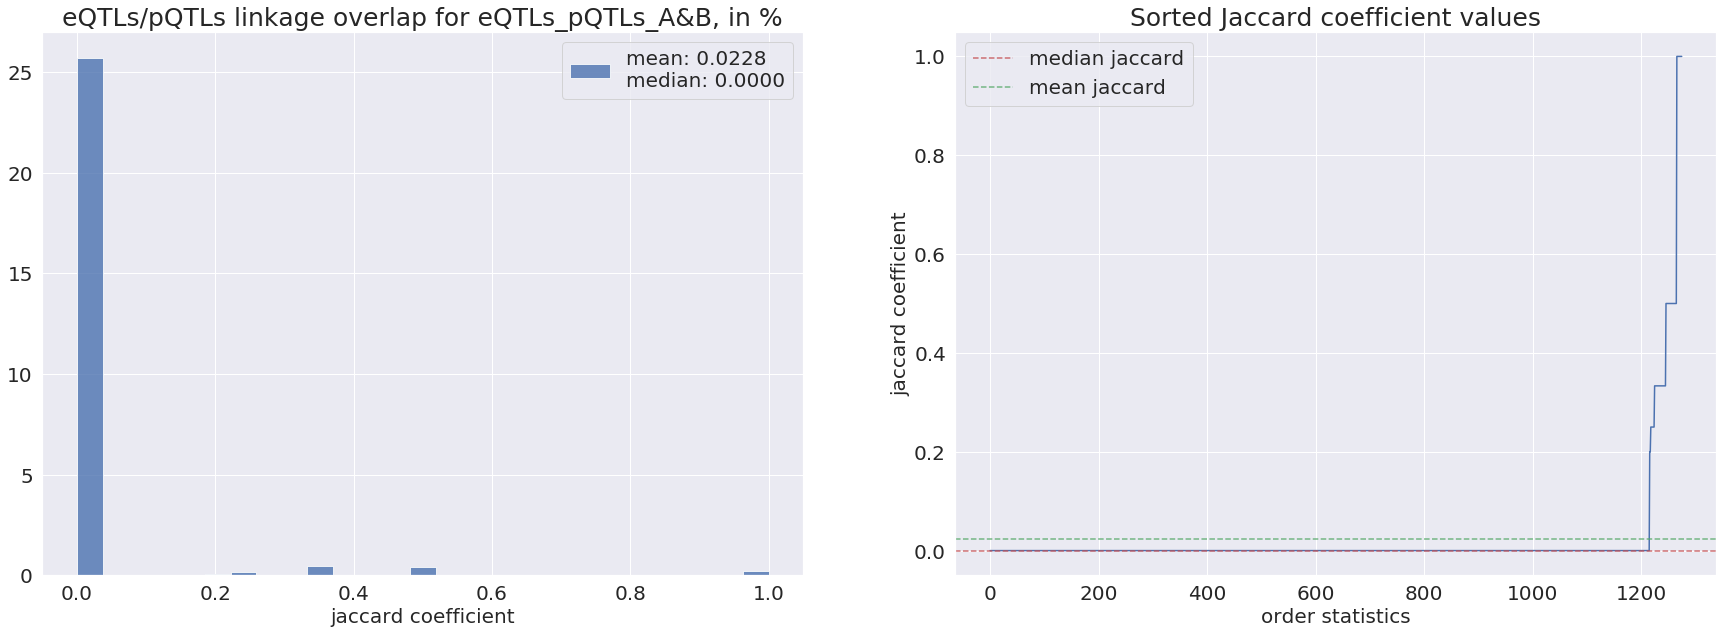

In [15]:
gene_pool = np.intersect1d(expression_df["eQTLs_2011"]["gene"],
                           expression_df["pQTLs_2011"]["gene"])

linkage_overlap_data = []
for gene_name in gene_pool:
    linked_eQTLs = qtls.linked_markers(qtls_df["eQTLs_2011_A&B"],
                                       [gene_name])
    linked_pQTLs = qtls.linked_markers(qtls_df["pQTLs_2011_A&B"],
                                       [gene_name])
    linkage_overlap_data.append(
        qtls.jaccard(set(linked_eQTLs), set(linked_pQTLs)))

sns.set_style({'legend.frameon':True})
qtls.qtl_overlap_hist(linkage_overlap_data, "eQTLs_pQTLs_A&B")

Then ???  
What does this code do???

In [ ]:
""" Using simple PPIN-based test to assess whether interacting genes really have better eQTL/pQTL intersection 
    TODO: вычислять доверительные интервалы
"""

def eQTL_pQTL_similarity_ppin_test(qtl_type2graph, interactome_graph):
    scores = []
    for marker in np.intersect1d(
            qtl_type2graph["eQTLs"].vs.select(part=0)["name"],
            qtl_type2graph["pQTLs"].vs.select(part=0)["name"]):
        linked = {}
        for qtl_type in ["eQTLs", "pQTLs"]:
            linked[qtl_type] = set(qtl_type2graph[qtl_type].vs[qtl_type2graph[
                qtl_type].neighborhood(marker, mode="out")]["name"])
            linked[qtl_type].remove(marker)
        matches = len(linked["eQTLs"] & linked["pQTLs"])
        tests_count = len(linked["eQTLs"]) * len(linked["pQTLs"])
        for qtl_type in ["eQTLs", "pQTLs"]:
            linked[qtl_type] &= set(interactome_graph.vs["name"])
        for eQTL_gene in linked["eQTLs"]:
            for pQTL_gene in linked["pQTLs"]:
                if eQTL_gene != pQTL_gene \
                        and interactome_graph.are_connected(eQTL_gene, pQTL_gene):
                    matches += 1
        scores.append(matches / tests_count)
    return np.mean(scores)


tuples_for_df = []
for LOD_cutoff in tqdm_notebook(np.arange(0, 6)):  #10. ** np.arange(-5, -1):
    qtl_graph = {"eQTLs" : networks.graph_from_edges(qtls_df["eQTLs_2011_A&B"]\
                                                     .query("LOD >= {}".format(LOD_cutoff))\ #.query("q_value <= {}".format(q_cutoff))
                                                     [["SNP", "gene"]].values, directed=True),
                 "pQTLs" : networks.graph_from_edges(qtls_df["pQTLs_2011_A&B"]\
                                                     .query("LOD >= {}".format(LOD_cutoff))\ #.query("q_value <= {}".format(q_cutoff))
                                                     [["SNP", "gene"]].values, directed=True)}

    real_test_results = eQTL_pQTL_similarity_ppin_test(qtl_graph,
                                                       interactome_graph)
    randomized_test_results = []
    for i in range(INTERACTOME_RANDITER):
        with open(
                "./data/randomized_interactome_copies/physical/{}.pkl".format(
                    i), "rb") as pickle_file:
            randomized_interactome_graph = pickle.load(pickle_file)
            randomized_test_results.append(
                eQTL_pQTL_similarity_ppin_test(qtl_graph,
                                               randomized_interactome_graph))
    tuples_for_df.append((LOD_cutoff, real_test_results,
                          np.mean(randomized_test_results),
                          *util.confidence_interval(randomized_test_results)))

results_df = pd.DataFrame(
    tuples_for_df, columns=["LOD_cutoff", "real_mean", "random_mean", "CI_l", "CI_r"])
results_df.to_csv(
    "./data/interactions/eQTL_pQTL_intersection_A&B.csv",
    sep='\t',
    index=False)
display(results_df)

## Sophisticated tests